# Problemas de Radioastronomia

In [1]:
from dask.distributed import Client
from distributed.diagnostics import MemorySampler
client = Client()
client

<Client: 'tcp://127.0.0.1:45171' processes=4 threads=16, memory=15.00 GiB>

In [2]:
import dask
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from numba import jit, njit, prange, guvectorize, generated_jit
from numba import types as numba_types

In [3]:
# Crear imagen (ceros)
sz = da.linspace(0, 1, 1024)
x, y = da.meshgrid(sz, sz)
x = x.rechunk((512,512))
y = y.rechunk((512,512))

img = xr.DataArray(
  da.zeros((1024,1024), chunks=(512,512)), 
  dims=['i','j'],
  coords={'x':(['i', 'j'], x), 'y':(['i', 'j'], y)})
img

<xarray.DataArray 'zeros_like-f1c2026eacbde859efb72e37bfaa02a5' (i: 1024,
                                                                 j: 1024)>
dask.array<zeros_like, shape=(1024, 1024), dtype=float64, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
    x        (i, j) float64 dask.array<chunksize=(512, 512), meta=np.ndarray>
    y        (i, j) float64 dask.array<chunksize=(512, 512), meta=np.ndarray>
Dimensions without coordinates: i, j

In [4]:
from daskms import xds_from_ms, xds_from_table

In [5]:
ms_filename = 'co65/co65.ms'

In [6]:
# Leer dataset
dataset = xds_from_ms(
  ms_filename,
  taql_where="!FLAG_ROW",
  group_cols=["FIELD_ID", "DATA_DESC_ID"],
  index_cols=["SCAN_NUMBER", "TIME", "ANTENNA1", "ANTENNA2"]
)
uvw = dataset[0].UVW.data[:700].rechunk(100)
vis = dataset[0].DATA.data[:700].rechunk(100)

In [7]:
uvw

dask.array<rechunk-merge, shape=(700, 3), dtype=float64, chunksize=(100, 3), chunktype=numpy.ndarray>

In [23]:
vis

dask.array<rechunk-merge, shape=(700, 1, 2), dtype=complex64, chunksize=(100, 1, 2), chunktype=numpy.ndarray>

In [9]:
def block_gradient(uvw, vis, x, y):
  uv = uvw[0]
  ux = x[None, :, :] * uv[:, 0, None, None]
  vy = y[None, :, :] * uv[:, 1, None, None]
  upv = ux + vy
  res_broad = np.cos(upv)[:, None, None, :, :] * vis.real[..., None, None]
  res_broad += np.sin(upv)[:, None, None, :, :] * vis.imag[..., None, None]
  res = res_broad.sum(axis=(0, 2), keepdims=True)
  return res
  
  

data_img = da.blockwise(
  block_gradient,
  ("row", "chan", "corr", "i", "j"),
  uvw,
  ("row", "uvw"),
  vis,
  ("row", "chan", "corr"),
  img.x.data,
  ("i", "j"),
  img.y.data,
  ("i", "j"),
  adjust_chunks = {
    "row" : 1,
    "corr" : 1
  },
  dtype = np.float64
)

  
  

In [29]:
data_img.chunks

((1, 1, 1, 1, 1, 1, 1), (1,), (1,), (512, 512), (512, 512))

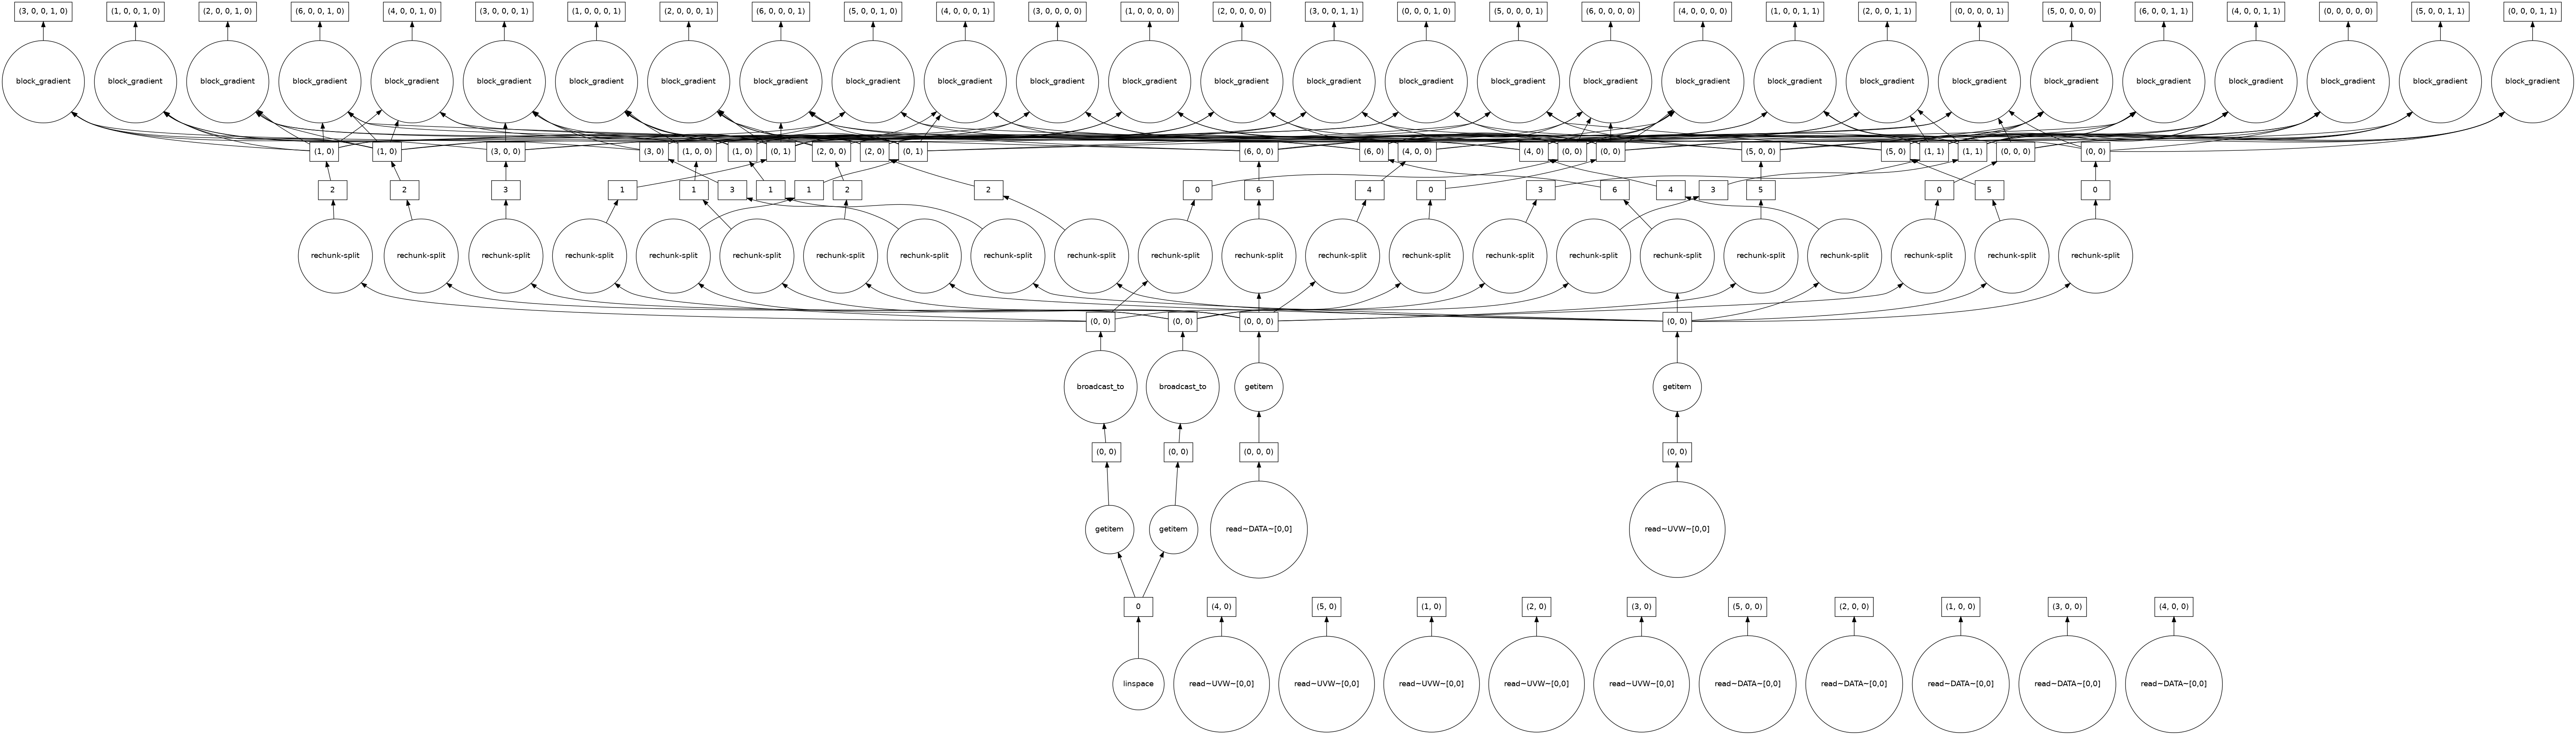

In [11]:
data_img.visualize()

In [12]:
ms = MemorySampler()

In [13]:
with ms.sample("no numba"):                    
  di1 = data_img[0,:,0,:,:].compute()

2023-06-16 17:28:15,961 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.72 GiB -- Worker memory limit: 3.75 GiB
2023-06-16 17:28:16,282 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.01 GiB -- Worker memory limit: 3.75 GiB
2023-06-16 17:28:16,353 - distributed.worker.memory - WARNING - Worker is at 76% memory usage. Resuming worker. Process memory: 2.87 GiB -- Worker memory limit: 3.75 GiB


<Axes: xlabel='time', ylabel='Cluster memory (GiB)'>

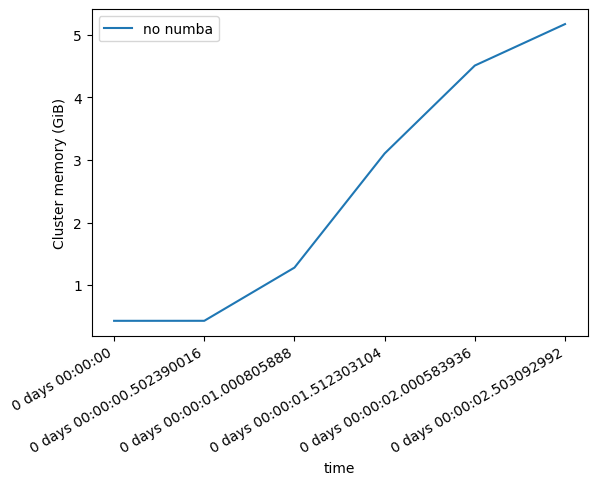

In [14]:
ms.plot(align=True)

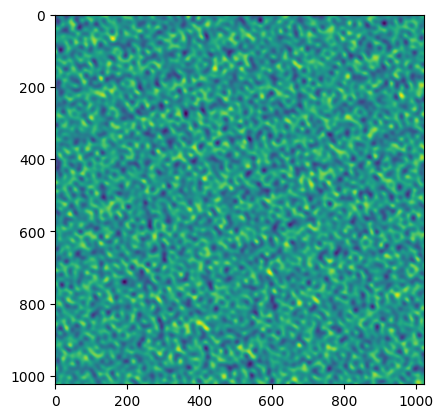

In [15]:
plt.imshow(di1[0])
plt.show()

In [16]:
def block_gradient_numba(uvw, vis, x, y):
  uv = uvw[0]
  u = uv[:, 0]
  v = uv[:, 1]
  res_s = block_gradient_njit(u, v, vis, x, y)
  res = res_s[None, :, None, :, :]
  return res

@njit(parallel=True, cache=True)
def block_gradient_njit(u, v, vis, x, y):
  ni = x.shape[0]
  nj = x.shape[1]
  nrows = vis.shape[0]
  nchan = vis.shape[1]
  ncorr = vis.shape[2]

  grad = np.zeros((nchan, ni, nj), dtype=np.float64)

  for i in prange(ni):
    for j in range(nj): 
      for r in range(nrows):
        upv = u[r] * x[i,j] + v[r] * y[i,j]
        cosupv = np.cos(upv)
        sinupv = np.sin(upv)
        for c in range(nchan):
          for o in range(ncorr):
            aux = vis.real[r, c, o] * cosupv + vis.imag[r, c, o] * sinupv
            grad[c, i, j] += aux
  
  return grad

In [17]:
data_img_2 = da.blockwise(
  block_gradient_numba,
  ("row", "chan", "corr", "i", "j"),
  uvw,
  ("row", "uvw"),
  vis,
  ("row", "chan", "corr"),
  img.x.data,
  ("i", "j"),
  img.y.data,
  ("i", "j"),
  adjust_chunks = {
    "row" : 1,
    "corr" : 1
  },
  dtype = np.float64
)

In [18]:
data_img_2

dask.array<block_gradient_numba, shape=(7, 1, 1, 1024, 1024), dtype=float64, chunksize=(1, 1, 1, 512, 512), chunktype=numpy.ndarray>

In [25]:
with ms.sample("numba"):                    
  di2 = data_img_2[0,:,0,:,:].compute()

<Axes: xlabel='time', ylabel='Cluster memory (GiB)'>

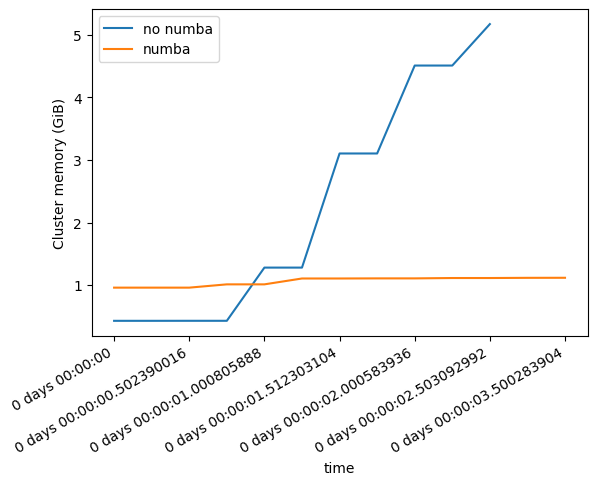

In [26]:
ms.plot(align=True)

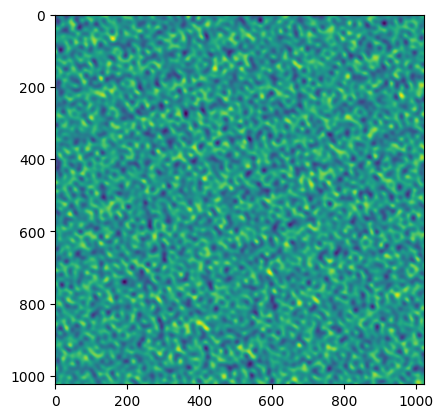

In [21]:
plt.imshow(di2[0])
plt.show()

In [22]:
client.shutdown()